# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- mettre au propre les commentaires de l'étape 3

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math
import cv2

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.8
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Open camera
cap = cv2.VideoCapture(0)
if cap.isOpened() == False:
    print("Erreur: Impossible d'ouvrir la webcam.")

time.sleep(2)
ret, frame = cap.read()
    
if ret == False:
    print("Erreur: Impossible de capturer l'image.")


In [6]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [7]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [8]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(651, 992), (1015, 992), (1015, 462), (651, 462)], [(476, 1080), (994, 1080), (994, 663), (476, 663)]]
Centroid de la goal area : [1632.   572.5]
Vecteur direction du robot : 93 -5
Centroid du robot : [476 599]


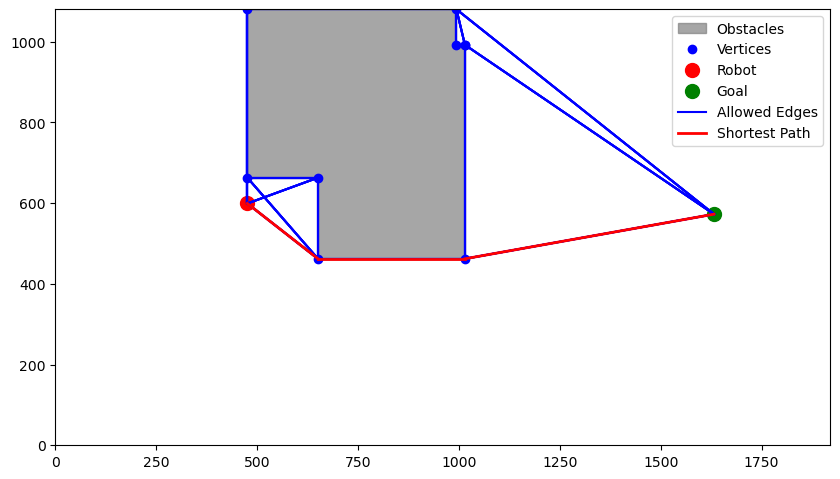

In [9]:
ret, frame = cap.read()

# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal(frame)
robot_centroid, robot_direction = vision.vision_robot(frame)

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot(frame)

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration :  1
Kalman:  x:  25.0 , y:  32.0 , angle:  -0.053711729303232585
Rotation state:
Robot angle:  [-0.05371173] , Goal angle:  [-0.67474094] , Rotation to achieve:  [-0.62102921]
Iteration :  2
Kalman:  x:  25.028711608678837 , y:  31.998456365124795 , angle:  -0.053711729303232585
Rotation state:
Robot angle:  [-0.05371173] , Goal angle:  [-0.67604977] , Rotation to achieve:  [-0.62233804]
Iteration :  3
Kalman:  x:  25.161781288825075 , y:  31.991497718167974 , angle:  -0.062913957290495
Rotation state:
Robot angle:  [-0.06291396] , Goal angle:  [-0.68219072] , Rotation to achieve:  [-0.61927677]
Iteration :  4
Kalman:  x:  25.26908149615369 , y:  31.98643335849965 , angle:  -0.10907605412779253
Rotation state:
Robot angle:  [-0.10907605] , Goal angle:  [-0.68725256] , Rotation to achieve:  [-0.5781765]
Iteration :  5
Kalman:  x:  25.308510858105944 , y:  31.982395156542616 , angle:  -0.1865782962680475
Rotation state:
Robot angle:  [-0.1865783] , Goal angle:  [-0.68899625] ,

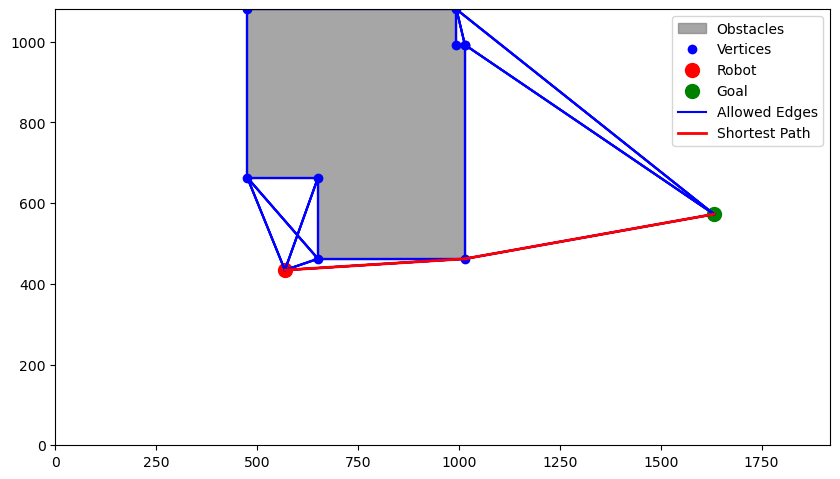

centroid camera:  (30, 23)
glob nav path : [(54, 24), (88, 30)]
Iteration :  27
Kalman:  x:  30.000472130520798 , y:  22.999788268177014 , angle:  -0.8602358726286257
Rotation state:
Robot angle:  [-0.86023587] , Goal angle:  [0.0416522] , Rotation to achieve:  [0.90188808]
Iteration :  28
Kalman:  x:  30.697527291818353 , y:  22.18973160490354 , angle:  -0.8644352651097367
Rotation state:
Robot angle:  [-0.86443527] , Goal angle:  [0.07752996] , Rotation to achieve:  [0.94196523]
Iteration :  29
Kalman:  x:  31.16177807126086 , y:  21.632260853430832 , angle:  -0.8407031351417793
Rotation state:
Robot angle:  [-0.84070314] , Goal angle:  [0.10330534] , Rotation to achieve:  [0.94400848]
Iteration :  30
Kalman:  x:  31.34092371336252 , y:  21.427701249247914 , angle:  -0.7759448509075401
Rotation state:
Robot angle:  [-0.77594485] , Goal angle:  [0.11303786] , Rotation to achieve:  [0.88898271]
Iteration :  31
Kalman:  x:  31.423218457055743 , y:  21.348114862254494 , angle:  -0.694276

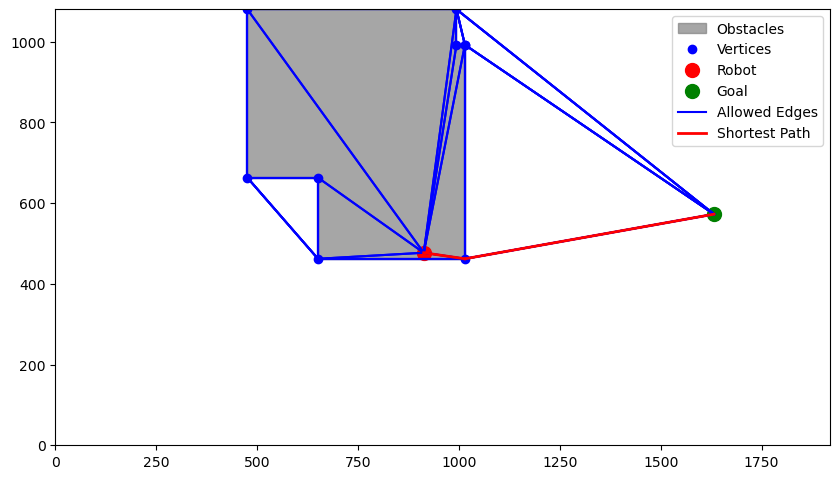

centroid camera:  (49, 25)
glob nav path : [(54, 24), (88, 30)]
Iteration :  65
Kalman:  x:  49.00052810338664 , y:  25.000146467072966 , angle:  0.15356496263049413
Rotation state:
Robot angle:  [0.15356496] , Goal angle:  [-0.19744404] , Rotation to achieve:  [-0.35100901]
Iteration :  66
Kalman:  x:  50.08596835175853 , y:  25.168155833124846 , angle:  0.14794532053731438
Rotation state:
Robot angle:  [0.14794532] , Goal angle:  [-0.29003724] , Rotation to achieve:  [-0.43798256]
Iteration :  67
Kalman:  x:  50.821701717724665 , y:  25.28313285835087 , angle:  0.12293600708183383
Rotation state:
Robot angle:  [0.12293601] , Goal angle:  [-0.38370652] , Rotation to achieve:  [-0.50664253]
Iteration :  68
Kalman:  x:  51.06338749084624 , y:  25.31628604039751 , angle:  0.06168967093726521
Rotation state:
Robot angle:  [0.06168967] , Goal angle:  [-0.42138335] , Rotation to achieve:  [-0.48307302]
Iteration :  69
Kalman:  x:  51.15112133956504 , y:  25.32174037154015 , angle:  -0.02067

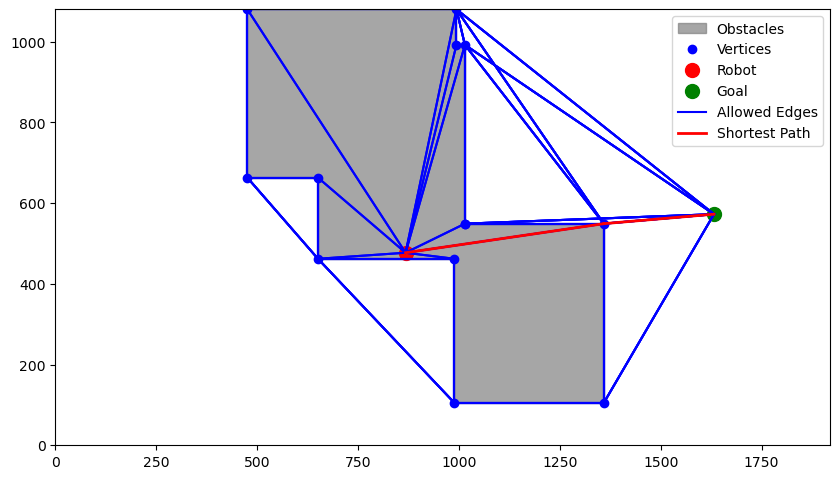

centroid camera:  (46, 25)
glob nav path : [(73, 29), (88, 30)]
Iteration :  79
Kalman:  x:  46.0011739861951 , y:  25.000397055346607 , angle:  -0.7121161805228882
Rotation state:
Robot angle:  [-0.71211618] , Goal angle:  [0.14707027] , Rotation to achieve:  [0.85918645]
Iteration :  80
Kalman:  x:  45.4565010046507 , y:  25.470598957311694 , angle:  -0.7239876088147955
Rotation state:
Robot angle:  [-0.72398761] , Goal angle:  [0.12744466] , Rotation to achieve:  [0.85143227]
Iteration :  81
Kalman:  x:  44.906384538618035 , y:  25.96382627092219 , angle:  -0.7149169141867867
Rotation state:
Robot angle:  [-0.71491691] , Goal angle:  [0.10765561] , Rotation to achieve:  [0.82257252]
Iteration :  82
Kalman:  x:  44.63984355969551 , y:  26.20373269389673 , angle:  -0.6652197736218645
Rotation state:
Robot angle:  [-0.66521977] , Goal angle:  [0.09828078] , Rotation to achieve:  [0.76350056]
Iteration :  83
Kalman:  x:  44.53839100220356 , y:  26.28327012267574 , angle:  -0.58847676044

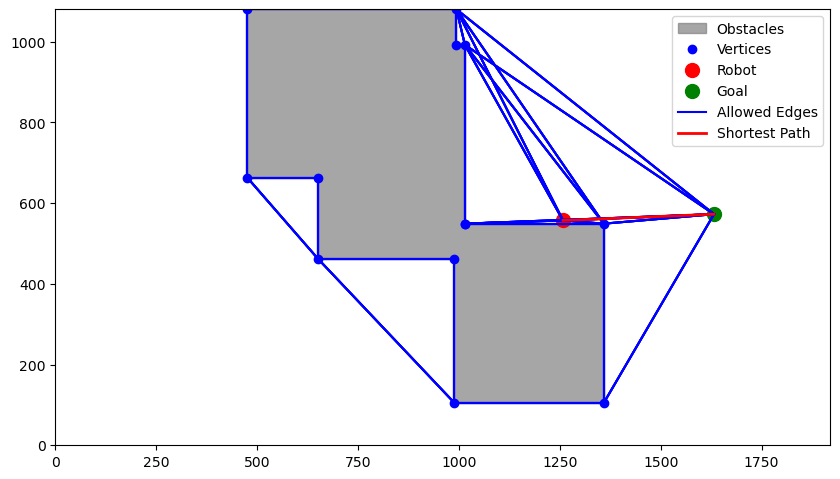

centroid camera:  (68, 30)
glob nav path : [(88, 30)]
Iteration :  121
Kalman:  x:  68.0004202662919 , y:  30.00017307444243 , angle:  0.28086146366160103
Rotation state:
Robot angle:  [0.28086146] , Goal angle:  [-8.65390397e-06] , Rotation to achieve:  [-0.28087012]
Iteration :  122
Kalman:  x:  68.90850399783852 , y:  30.262141906586518 , angle:  0.2822230402911319
Rotation state:
Robot angle:  [0.28222304] , Goal angle:  [-0.01372996] , Rotation to achieve:  [-0.295953]
Iteration :  123
Kalman:  x:  69.49852980333401 , y:  30.438726905183763 , angle:  0.26446297858240386
Rotation state:
Robot angle:  [0.26446298] , Goal angle:  [-0.02370864] , Rotation to achieve:  [-0.28817162]
Iteration :  124
Kalman:  x:  69.70682120426659 , y:  30.498969040270755 , angle:  0.2072456489004583
Rotation state:
Robot angle:  [0.20724565] , Goal angle:  [-0.02726947] , Rotation to achieve:  [-0.23451512]
Iteration :  125
Kalman:  x:  69.76072403398607 , y:  30.50961780439035 , angle:  0.126896106982

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 

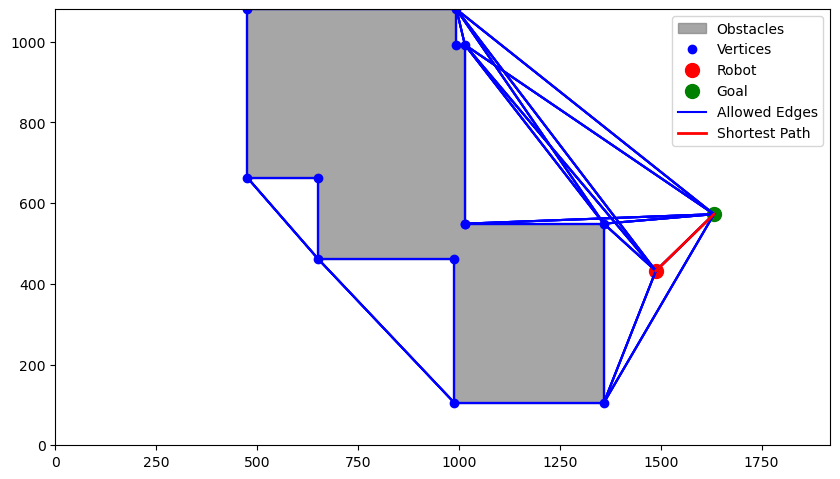

centroid camera:  (80, 23)
glob nav path : [(88, 30)]
Iteration :  148
Kalman:  x:  80.00053287747258 , y:  22.999977318574032 , angle:  -0.77665216663366
Rotation state:
Robot angle:  [-0.77665217] , Goal angle:  [0.71886462] , Rotation to achieve:  [1.49551678]
Iteration :  149
Kalman:  x:  79.95570188197347 , y:  23.044046553079262 , angle:  -0.7968255267995008
Rotation state:
Robot angle:  [-0.79682553] , Goal angle:  [0.71296998] , Rotation to achieve:  [1.50979551]
Iteration :  150
Kalman:  x:  79.95703328322277 , y:  23.04284875509942 , angle:  -0.7767499985559864
Rotation state:
Robot angle:  [-0.77675] , Goal angle:  [0.71313707] , Rotation to achieve:  [1.48988707]
Iteration :  151
Kalman:  x:  79.9620219302237 , y:  23.03790729941036 , angle:  -0.714649478551988
Rotation state:
Robot angle:  [-0.71464948] , Goal angle:  [0.71379543] , Rotation to achieve:  [1.42844491]
Iteration :  152
Kalman:  x:  79.96712797419605 , y:  23.033358309000068 , angle:  -0.6305746831216349
Rota

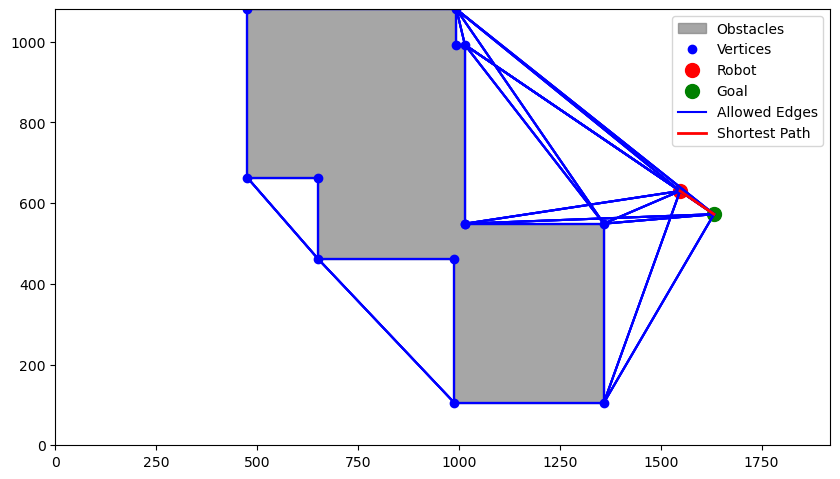

centroid camera:  (83, 34)
glob nav path : [(88, 30)]
Iteration :  181
Kalman:  x:  83.0009307088706 , y:  33.99882135497802 , angle:  1.1913683428436754
Rotation state:
Robot angle:  [1.19136834] , Goal angle:  [-0.67468799] , Rotation to achieve:  [-1.86605634]
Iteration :  182
Kalman:  x:  83.14022611213551 , y:  34.34817989026743 , angle:  1.2053997478480127
Rotation state:
Robot angle:  [1.20539975] , Goal angle:  [-0.72989522] , Rotation to achieve:  [-1.93529497]
Iteration :  183
Kalman:  x:  83.22215634552022 , y:  34.56442293936085 , angle:  1.201656555747294
Rotation state:
Robot angle:  [1.20165656] , Goal angle:  [-0.7625575] , Rotation to achieve:  [-1.96421405]
Iteration :  184
Kalman:  x:  83.2706824980317 , y:  34.69869538757404 , angle:  1.1557342255711958
Rotation state:
Robot angle:  [1.15573423] , Goal angle:  [-0.78215018] , Rotation to achieve:  [-1.93788441]
Iteration :  185
Kalman:  x:  83.29047380766853 , y:  34.74400988644064 , angle:  1.0794586835795696
Rotat

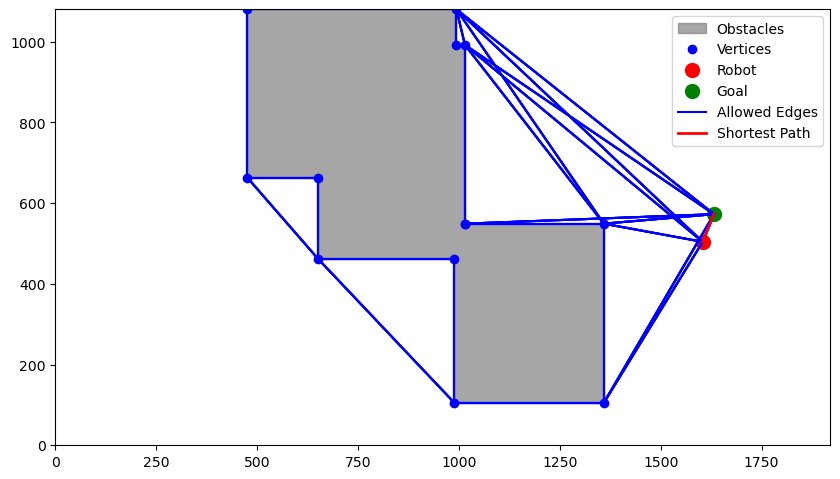

centroid camera:  (86, 27)
glob nav path : []
Iteration :  215
Thymio arrived in the goal area, congratulations!


In [10]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

old_time = 0.0
iter = 0


while(cap.isOpened()):
    
    if iter == 0:                   
        old_time = time.time()
        
    dt = time.time() - old_time     # get time difference for Kalman 
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter = iter + 1
    print("Iteration : ", iter)

    
    # Check if the robot is arrived to the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        break
    
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    
    # Prox sensors detect something, we call the local navigation
    if detected == True:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE

        
    #CA SERT A QUOI RAPH? A mettre dans une fonction?
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        # Compute the difference between the robot direction and the direction of the goal
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], 
                           intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        # Define the turning orientation
        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise

        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise

        # Check the orientation of the robot
        if(abs(angle) < ROT_ACCURACY):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue
        
        
        
    elif global_state == TRANSLATION_STATE:
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]
        
        # Check if the robot achieve the intermediate goal
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        # Check if the robot orientation change a lot from its goal direction
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
        
    elif global_state == CAMERA_STATE:
        print("Camera state:")
        robot_centroid = [0,0]
        
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            ret, frame = cap.read()
            robot_centroid, robot_direction = vision.vision_robot(frame)
            
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        
        # Convert in centimeter for the Kalman filter
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        intermediate_goals = shortest_path
        # Delete the first goal because it's the robot position
        intermediate_goals.pop(0)
        
        # Check if the robot achieve the next goal, if yes it can target the next one
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("glob nav path :", intermediate_goals)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("Local avoidance state:")
        
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        # Check if we detect an already known obstacle or an other one
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        # Add the new obstacle to the list
        obstacles.append(Object)
        prox_sensors_bool = True
        
        # The robot is backwarding in order to avoid the obstacle
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [32]:
await stop_robot()       #A RETIRER LORS DU RENDU, CAR NON UTILE